# Teoria

**Probabilità condizionata**

misura della probabilità che un evento accada dato un altro evento già accaduto $P(B|A)$ probabilità che accada B dato A

**Teorema di Bayes**

$P(A|B) = \frac{P(A \bigcap B)}{P(B)} = \frac{P(A)*P(B|A)}{P(B)}$ 

dove $P(A \cap B)$ è la probabilità che avvengano entrambi

**modelli e algoritmi naive bayes**

due importanti assunzioni su dati:
- feature tra loro indipendenti
- feature hanno tutte lo stesso peso

$P(y|x_1,...,x_n)=\frac{P(y)P(x_1,...,x_n)}{P(x_1,...,x_n)} = \frac{P(y)P(x1|y)...P(x_n|y)}{P(x1)...P(x_n)} = \frac{P(y)\prod_{i=1}^n P(x_i|y)}{P(x1)...P(x_n)}$

il denominatore è costante per qualunque valore di y, lo posso rimuovere usando il simbolo $\propto$

$P(y|x_1,...,x_n) \propto P(y)\prod_{i=1}^n P(x_i|y)$

Hai osservato in passato:

La parola “gratis” compare spesso in email spam.

La parola “ciao” compare più spesso nelle email normali.

Ora arriva un’email con scritto:

"Ciao! Hai vinto un premio gratis!"

Il modello guarda le tre parole:
ciao, vinto, gratis.

E pensa:

“Ciao” → di solito è in email non spam.

“Gratis” → quasi sempre in email spam.

“Vinto” → spesso in email spam.

Allora conclude:

"Mmh... più probabilmente è spam, quindi la classifico così."

🧠 Perché si chiama Naive (ingenuo)?
Perché fa finta che ogni parola sia indipendente dalle altre.
Cioè pensa che il fatto che ci sia “gratis” non influenzi il fatto che ci sia anche “vinto”.

Nella realtà questo non è vero, ma sorprendentemente... funziona lo stesso molto bene!

**regola di classificazione** <br>
$ y = \argmax_y P(y) \prod_{i=1}^n P(x_i|y)$

- utilizzabile solo per dati discreti
- tende all'overfitting (poiche si basa troppo su dati di training)

si fanno assunzioni su $P(x|y)$, i diversi algoritmi NB differiscono in questo

**Multinomial NB**

$P(x_i|y) = \frac{N_{yi}+\alpha}{N_y+\alpha n}$

- valido per dati multinomiali
- $N_{yi}$ osservazioni della feaure i per la classe y
- $N_y$ frequenza della feature i in tutte le obs
- $\alpha$ iperparam usato per evitare che si azzeri la prob se una feature non presente

Supponiamo di avere un dataset con queste colonne:
- feature_1: altezza
- feature_2: peso
- y: etichetta di classe (0 = sano, 1 = malato)

<br>Se diciamo:"Osservazioni della feature 1 nella classe y = 1"
<br>significa:"I valori di altezza (feature_1) solo per i pazienti malati (cioè quelli con y = 1)".

**Gaussian NB**

$P(X_i|Y) = \frac{1}{\sqrt{2 \pi\sigma_y^2}}exp\big(-\frac{(x_i-\mu_y)^2}{2 \sigma_y^2})$

- $\sigma$ deviazione std
- $\mu$ media

**Pro NB**
- algoritmi veloci
- poco soggetto alla dimensionalità 
<br> <br> <br>

**contro NB**

- assunzioni imporanti su dati 
- scarso come stimatore

# Pratica

In [200]:
from sklearn.datasets import make_gaussian_quantiles, load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, classification_report, confusion_matrix
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [201]:
RANDOM_SEED = 0

## Gaussian NB

assume che la distribuzione della probabilità $X|Y$ sia una gaussiana

In [202]:
from sklearn.naive_bayes import GaussianNB

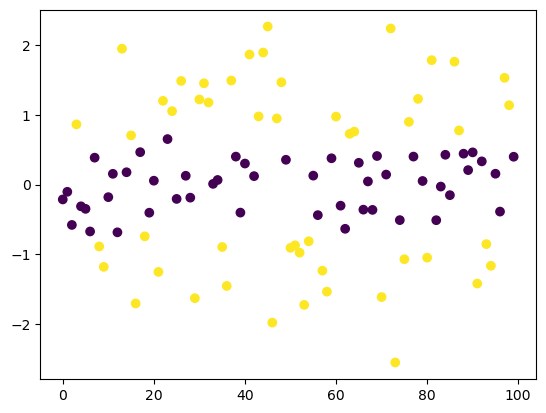

In [203]:
X, y = make_gaussian_quantiles(
    n_features=1,
    n_classes=2,
    random_state=RANDOM_SEED
)

plt.scatter(np.arange(X.shape[0]), X, c=y)

proviamo una classificazione con logistica

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=RANDOM_SEED)
X_train.shape

(70, 1)

score usato da metodo score è accuracy media che vale 0.37, se avessi lanciato una moneta (0.5) avrei fatto meglio, il modello è peggiore di un classificatore casuale

In [205]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.36666666666666664

tutto al di sotto della retta viene classificato come classe negativa, ciò ch è sopra viene classificato come classe positiva

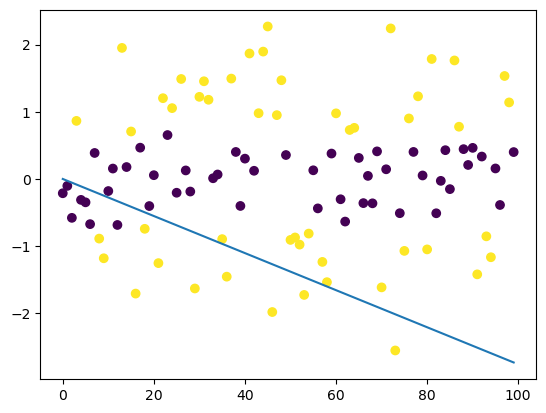

In [206]:
a = np.arange(X.shape[0])
plt.scatter(a, X, c=y)
plt.plot(a, a*lr.coef_[0], + lr.intercept_)

### testiamo il Gaussian

In [207]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.9333333333333333

In [208]:
y_proba = gnb.predict_proba(X_test)
log_loss(y_test, y_proba)


0.18879658207548125

## Bernoulli NB

distribuzione usata è una bernoulliana <br>
eventi binari <br>
possibile valore racchiuso tra 0 e 1, accaduto e non accaduto

### modello spam sms

In [209]:
BASE_URL = 'https://raw.githubusercontent.com/ProfAI/machine-learning-modelli-e-algoritmi/3a3ea7a52fcc36781559a2a3071bdab6a09bcfbe/datasets/'

In [210]:
df = pd.read_csv(BASE_URL+'spam.csv')
df.head()

,Unnamed: 0,MESSAGE,SPAM
0,2348,That seems unnecessarily affectionate,False
1,762,Urgent Ur å£500 guaranteed award is still uncl...,True
2,3298,Honeybee Said: *I'm d Sweetest in d World* God...,False
3,3104,Or remind me in a few hrs.,False
4,4241,Show ur colours! Euro 2004 2-4-1 Offer! Get an...,True


1. costruzione del vocabolario, seconda soluzione più efficiente

In [211]:
len(df)

1000

In [212]:
def build_vocab(corpus):

    vocab = []
    for doc in corpus:
        for word in doc.split():
            if word.lower() not in vocab:
                vocab.append(word.lower())
    
    return vocab

def build_vocab_eff(corpus):

    vocab = set({})

    for doc in corpus:
        vocab = vocab.union(set(doc.lower().split()))
    
    return list(vocab)

corpus = ["anvedi come balla nando", "peppe è figo", "bella per te", "ciao come stai"]

In [213]:
build_vocab_eff(corpus)

['peppe',
 'balla',
 'figo',
 'te',
 'ciao',
 'stai',
 'anvedi',
 'per',
 'bella',
 'nando',
 'come',
 'è']

2. creaiamo il bag of words

In [214]:
def binary_bow(corpus, vocab = None):

    if vocab is None:
       vocab = build_vocab_eff(corpus)
    
    vocab_size = len(vocab)
    docs_bow = []

    for doc in corpus:
        doc_bow = [0]*vocab_size
        for i in range(vocab_size):
            doc_bow[i] = int(vocab[i] in doc)
        docs_bow.append(doc_bow)

    return docs_bow

binary_bow(corpus)

[[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0],
 [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]]

3. codifichiamo il reale corpus del df

In [215]:
sms_list = df["MESSAGE"].to_list()
sms_list[:5]

['That seems unnecessarily affectionate',
 'Urgent Ur å£500 guaranteed award is still unclaimed! Call 09066368327 NOW closingdate04/09/02 claimcode M39M51 å£1.50pmmorefrommobile2Bremoved-MobyPOBox734LS27YF',
 "Honeybee Said: *I'm d Sweetest in d World* God Laughed &amp; Said: *Wait,U Havnt Met d Person Reading This Msg* MORAL: Even GOD Can Crack Jokes! GM+GN+GE+GN:)",
 'Or remind me in a few hrs.',
 'Show ur colours! Euro 2004 2-4-1 Offer! Get an England Flag & 3Lions tone on ur phone! Click on the following service message for info!']

In [216]:
sms_bow = binary_bow(sms_list)
len(sms_bow[0])

4847

In [217]:
X = sms_bow
y = df["SPAM"].to_list()

In [218]:
X_train_sms, X_test_sms, y_train_sms, y_test_sms = train_test_split(X, y, test_size=.3, random_state=RANDOM_SEED)


In [219]:
from sklearn.naive_bayes import BernoulliNB

In [220]:
bnb = BernoulliNB()
bnb.fit(X_train_sms, y_train_sms)
report = classification_report(bnb.predict(X_test_sms), y_test_sms)

In [221]:
print(report)

              precision    recall  f1-score   support

       False       0.99      0.92      0.95       155
        True       0.92      0.99      0.95       145

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.96      0.95      0.95       300



## Multinomial NB

se volessi usare bow originale, non basta occorrenza della parola (1 o 0) ma il conteggio di essa, quante volte appare

In [222]:
df = pd.read_csv(BASE_URL+'spam.csv')
df.head()

,Unnamed: 0,MESSAGE,SPAM
0,2348,That seems unnecessarily affectionate,False
1,762,Urgent Ur å£500 guaranteed award is still uncl...,True
2,3298,Honeybee Said: *I'm d Sweetest in d World* God...,False
3,3104,Or remind me in a few hrs.,False
4,4241,Show ur colours! Euro 2004 2-4-1 Offer! Get an...,True


In [223]:
def bow(corpus, vocab = None):

    if vocab is None:
        vocab = build_vocab_eff(corpus)

    vocab_size = len(vocab)
    docs_bow = []

    for doc in corpus:
        doc_bow = [0]*vocab_size
        for i in range(vocab_size):
            doc_bow[i] = doc.split().count(vocab[i])
        docs_bow.append(doc_bow)

    return docs_bow

In [224]:
corpus1 = ["anvedi come balla balla nando", "anvedi la fine del mondo", "peppe è figo", "bella per te", "ciao come stai"]
bow(corpus1)

[[0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
 [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]]

In [225]:
X = sms_bow
y = df['SPAM'].to_list()
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X,y, train_size=.3, random_state=RANDOM_SEED)


In [226]:
from sklearn.naive_bayes import MultinomialNB

In [227]:
mnb = MultinomialNB()
mnb.fit(X_train_bow, y_train_bow)
report = classification_report( y_test_bow, mnb.predict(X_test_bow))
print(report)

              precision    recall  f1-score   support

       False       0.95      0.94      0.95       337
        True       0.95      0.96      0.95       363

    accuracy                           0.95       700
   macro avg       0.95      0.95      0.95       700
weighted avg       0.95      0.95      0.95       700



## Complement NB (variante del multinomial)

con dataset sbilanciati lavora meglio

In [228]:
from sklearn.naive_bayes import ComplementNB

In [229]:
df = pd.read_csv(BASE_URL + 'spam_unbalanced.csv')
df.head()

,Unnamed: 0,MESSAGE,SPAM
0,0,You available now? I'm like right around hills...,False
1,1,Can a not?,False
2,2,Ok set let u noe e details later...,False
3,3,YOU ARE CHOSEN TO RECEIVE A å£350 AWARD! Pls c...,True
4,4,Hi baby ive just got back from work and i was ...,False


dataset fortemente sbilanciato

In [230]:
df['SPAM'].value_counts()/len(df)*100

False    86.6
True     13.4
Name: SPAM, dtype: float64

usiamo la funzione originale bow di sklearn

In [231]:
from sklearn.feature_extraction.text import CountVectorizer

In [232]:
X = df['MESSAGE']
y = df['SPAM']

In [233]:
X_train_compl, X_test_compl, y_train_compl, y_test_compl = train_test_split(X,y,test_size=.3, random_state=RANDOM_SEED)


In [234]:
bow = CountVectorizer(stop_words="english", max_features=1000)


In [235]:
X_train_compl = bow.fit_transform(X_train_compl)
X_test_compl = bow.transform(X_test_compl)
X_train_compl.shape

(700, 1000)

il modello classifica troppi elementi come appartenenti alla classe positiva

In [236]:
cnb = ComplementNB()
cnb.fit(X_train_compl, y_train_compl)
report = classification_report(y_test_compl, cnb.predict(X_test_compl))
print(report)

              precision    recall  f1-score   support

       False       0.99      0.93      0.96       258
        True       0.68      0.93      0.79        42

    accuracy                           0.93       300
   macro avg       0.84      0.93      0.87       300
weighted avg       0.95      0.93      0.93       300



In [237]:
confusion_matrix(y_test_compl, cnb.predict(X_test_compl))

array([[240,  18],
       [  3,  39]])

### vediamo come si comporta un modello multinomiale che non gestisce i dati sbilanciati

In [238]:
mnb = MultinomialNB()
mnb.fit(X_train_compl, y_train_compl)
print(classification_report(y_test_compl, mnb.predict(X_test_compl)))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99       258
        True       0.95      0.88      0.91        42

    accuracy                           0.98       300
   macro avg       0.96      0.94      0.95       300
weighted avg       0.98      0.98      0.98       300



In [239]:
confusion_matrix(y_test_compl, mnb.predict(X_test_compl))

array([[256,   2],
       [  5,  37]])

## Categorical NB

assume che le categorie siano codificate con un numero (ORDINAL ENCODER)

In [240]:
BASE_URL = 'https://raw.githubusercontent.com/ProfAI/machine-learning-fondamenti/refs/heads/main/datasets/housing.csv'
df = pd.read_csv(BASE_URL, usecols=['ZN', 'CHAS', 'RAD', 'PRICE'])
df.head()

,ZN,CHAS,RAD,PRICE
0,18.0,0.0,1.0,24.0
1,0.0,0.0,2.0,21.6
2,0.0,0.0,2.0,34.7
3,0.0,0.0,3.0,33.4
4,0.0,0.0,3.0,36.2


In [241]:
from sklearn.preprocessing import OrdinalEncoder

i naive bayes sono ottimi classificatori ma pessimi regressori, per questo sono implementati su sklearn SOLO come classificatori. <br>

trasformiamo per questo il problema

In [248]:
def price_to_category(price):

    CATEGORIES = ['VERY CHEAP', 'CHEAP', 'AVERAGE', 'EXPENSIVE', 'VERY EXPENSIVE']

    for i in range(1,5):
        if price < df['PRICE'].quantile(0.2*i):
            return CATEGORIES[i]
    
    return CATEGORIES[-1]

df['PRICE'] = df['PRICE'].apply(price_to_category)
    
    


In [250]:
X = df.drop('PRICE', axis=1).values
y = df['PRICE'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=RANDOM_SEED)

oe  = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
X_train = oe.fit_transform(X_train)
X_test = oe.transform(X_test)

In [251]:
from sklearn.naive_bayes import CategoricalNB, GaussianNB

Gaussian peggiore del modello random

In [252]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test,y_test)

0.34868421052631576

In [253]:
catNB  =CategoricalNB()
catNB.fit(X_train, y_train)
catNB.score(X_test, y_test)

0.5

# Esercitazione

**Spam Filtering con Naive Bayes** <br><br>
Per questa esercitazione dovrai utilizzare l'intero dataset di sms di spam per creare un classificare di spam utilizzando un algoritmo Naive Bayes.

Task:
- Scarica il dataset da Kaggle (richiede un account gratuito), puoi farlo anche utilizzando le API.
- Processa il dataset per ottenere un dataframe con la stessa struttura di quello visto nelle lezioni di pratica.
- Costruisci e valuta i tuoi modelli ottimizzando le metriche che reputi corretto ottimizzare in base al problema affrontato.
- Una volta selezionato il modello finale, seleziona 3 email spam e 3 email non spam dalla tua casella di posta e prova ad usare il modello per classificarle. (n.b va bene anche se il tuo modello non le classifica tutte correttamente, ricorda che il dataset è di sms non di email)

### import dipendenze

In [256]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, BernoulliNB
from sklearn.metrics import log_loss, classification_report, confusion_matrix

In [254]:
USERNAME = 'adanfindo'
KEY = 'e8ddbc12e71afa38f8fae56df39b3ad1'

In [257]:
os.environ['USERNAME'] = 'adan findo'
os.environ['KEY'] = 'e8ddbc12e71afa38f8fae56df39b3ad1'

RANDOM_SEED = 0


In [258]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset


Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
100%|█████████████████████████████████████████| 211k/211k [00:00<00:00, 465kB/s]
100%|█████████████████████████████████████████| 211k/211k [00:00<00:00, 464kB/s]


In [259]:
!unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


### preprocessing dati

In [262]:
df = pd.read_csv('/Users/adanfindo/Desktop/ProAI-1/AI_developer/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [272]:
encoding = {'ham':0, 'spam':1}
df["v1"] = df["v1"].map(lambda x: encoding[x])
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,0,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,0,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,0,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
X = df['v2'].values
y = df['v1'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.3, random_state=RANDOM_SEED)

In [265]:
X_train = np.array(X_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)

In [266]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
X_train = ord_enc.fit_transform(X_train)
X_test = ord_enc.transform(X_test)

In [268]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')  # oppure 'mean' se numerico
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

0.8636247116124071
0.8636247116124071
0.8636247116124071
0.8636247116124071
